In [2]:
!pip install tpot

In [2]:
import pandas as pd
df = pd.read_excel('/content/imputed_missing_values_sklearn.xlsx')
df.shape

(1612, 17)

In [6]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

# Assuming df is your DataFrame and it's ready for use
X = df.drop('STATUS_dead_alive', axis=1)  # Features
y = df['STATUS_dead_alive']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
print(X_train.shape)
print(X_test.shape)
adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=10)  # Experiment with different values.
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)
X_train=X_train_resampled
y_train= y_train_resampled
print(X_train.shape)
print(X_test.shape)
# Create a DataFrame for the balanced training dataset
# balanced_train_df = pd.concat([X_train_resampled, y_train_resampled], axis=1)

# Initialize TPOTClassifier with F1 scoring for optimization
tpot = TPOTClassifier(generations=3, population_size=50, verbosity=2, scoring='f1_micro', random_state=42,
                      early_stop=3, config_dict="TPOT sparse")  # Use 'f1_micro' for F1 score

# Fit TPOT on the training data
tpot.fit(X_train, y_train)

# Print the training F1 score
train_f1 = tpot.score(X_train, y_train)
print("F1 Score on Training Set:", train_f1)

# Print the best pipeline's F1 score on the test set
test_f1 = tpot.score(X_test, y_test)
print("Best F1 Score on Test Set:", test_f1)

# Export the best pipeline as Python code
tpot.export('tpot_best_pipeline.py')


(1289, 16)
(323, 16)
(2338, 16)
(323, 16)


Optimization Progress:   0%|          | 0/200 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9216969563864638

Generation 2 - Current best internal CV score: 0.9216969563864638

Generation 3 - Current best internal CV score: 0.9216969563864638

Best pipeline: RandomForestClassifier(SelectPercentile(input_matrix, percentile=67), bootstrap=True, criterion=gini, max_features=0.7500000000000001, min_samples_leaf=8, min_samples_split=3, n_estimators=100)
F1 Score on Training Set: 0.9217279726261762
Best F1 Score on Test Set: 0.9287925696594427


In [1]:
tpot.export('optimized_pipeline.py')
from joblib import dump

NameError: name 'tpot' is not defined

In [18]:
from joblib import dump

# Save the trained TPOT model
dump(tpot.fitted_pipeline_, 'tpot_trained_model.joblib')


['tpot_trained_model.joblib']

In [19]:
from joblib import load
# Load the saved TPOT model
tpot_model = load('tpot_trained_model.joblib')

ROC AUC for Train Set: 0.9631113082000972
ROC AUC for Test Set: 0.9487450152474783


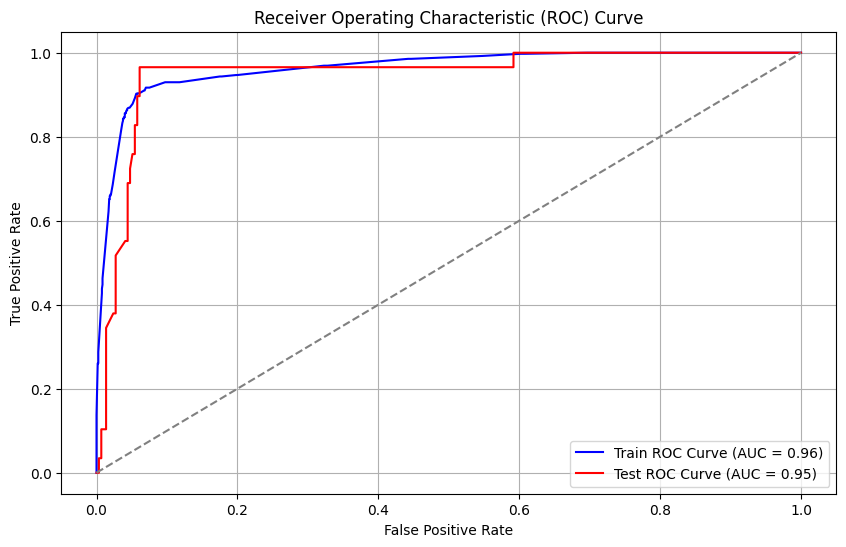

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Load the saved TPOT model
tpot_model = load('tpot_trained_model.joblib')

# Calculate ROC AUC for train and test sets
train_roc_auc = roc_auc_score(y_train, tpot_model.predict_proba(X_train)[:, 1])
test_roc_auc = roc_auc_score(y_test, tpot_model.predict_proba(X_test)[:, 1])

print("ROC AUC for Train Set:", train_roc_auc)
print("ROC AUC for Test Set:", test_roc_auc)

# Plot ROC curves
train_fpr, train_tpr, _ = roc_curve(y_train, tpot_model.predict_proba(X_train)[:, 1])
test_fpr, test_tpr, _ = roc_curve(y_test, tpot_model.predict_proba(X_test)[:, 1])

plt.figure(figsize=(10, 6))
plt.plot(train_fpr, train_tpr, label='Train ROC Curve (AUC = {:.2f})'.format(train_roc_auc), color='blue')
plt.plot(test_fpr, test_tpr, label='Test ROC Curve (AUC = {:.2f})'.format(test_roc_auc), color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the training and test sets
y_train_pred = tpot_model.predict(X_train)
y_test_pred = tpot_model.predict(X_test)

# Confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# True positive, true negative, false positive, false negative
tp_train, tn_train, fp_train, fn_train = conf_matrix_train.ravel()
tp_test, tn_test, fp_test, fn_test = conf_matrix_test.ravel()

# Sensitivity (True Positive Rate)
sensitivity_train = recall_score(y_train, y_train_pred)
sensitivity_test = recall_score(y_test, y_test_pred)

# Specificity (True Negative Rate)
specificity_train = tn_train / (tn_train + fp_train)
specificity_test = tn_test / (tn_test + fp_test)

# Recall
recall_train = recall_score(y_train, y_train_pred)
recall_test = recall_score(y_test, y_test_pred)

# Precision
precision_train = precision_score(y_train, y_train_pred)
precision_test = precision_score(y_test, y_test_pred)

# Accuracy
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

# F1 Score
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# Positive Predictive Value (PPV)
ppv_train = tp_train / (tp_train + fp_train)
ppv_test = tp_test / (tp_test + fp_test)

# Negative Predictive Value (NPV)
npv_train = tn_train / (tn_train + fn_train)
npv_test = tn_test / (tn_test + fn_test)

# Positive Likelihood Ratio (LR+)
lr_plus_train = sensitivity_train / (1 - specificity_train)
lr_plus_test = sensitivity_test / (1 - specificity_test)

# Negative Likelihood Ratio (LR-)
lr_minus_train = (1 - sensitivity_train) / specificity_train
lr_minus_test = (1 - sensitivity_test) / specificity_test

# Print results
print("Training Set:")
print("True Positive:", tp_train)
print("True Negative:", tn_train)
print("False Positive:", fp_train)
print("False Negative:", fn_train)
print("Sensitivity (Recall):", sensitivity_train)
print("Specificity:", specificity_train)
print("Precision:", precision_train)
print("Accuracy:", accuracy_train)
print("F1 Score:", f1_train)
print("Positive Predictive Value (PPV):", ppv_train)
print("Negative Predictive Value (NPV):", npv_train)
print("Positive Likelihood Ratio (LR+):", lr_plus_train)
print("Negative Likelihood Ratio (LR-):", lr_minus_train)

print("\nTest Set:")
print("True Positive:", tp_test)
print("True Negative:", tn_test)
print("False Positive:", fp_test)
print("False Negative:", fn_test)
print("Sensitivity (Recall):", sensitivity_test)
print("Specificity:", specificity_test)
print("Precision:", precision_test)
print("Accuracy:", accuracy_test)
print("F1 Score:", f1_test)
print("Positive Predictive Value (PPV):", ppv_test)
print("Negative Predictive Value (NPV):", npv_test)
print("Positive Likelihood Ratio (LR+):", lr_plus_test)
print("Negative Likelihood Ratio (LR-):", lr_minus_test)


Training Set:
True Positive: 1101
True Negative: 70
False Positive: 113
False Negative: 1054
Sensitivity (Recall): 0.9031705227077977
Specificity: 0.3825136612021858
Precision: 0.9377224199288257
Accuracy: 0.9217279726261762
F1 Score: 0.9201222173723266
Positive Predictive Value (PPV): 0.9069192751235585
Negative Predictive Value (NPV): 0.06227758007117438
Positive Likelihood Ratio (LR+): 1.462656687217053
Negative Likelihood Ratio (LR-): 0.2531399192067573

Test Set:
True Positive: 272
True Negative: 22
False Positive: 1
False Negative: 28
Sensitivity (Recall): 0.9655172413793104
Specificity: 0.9565217391304348
Precision: 0.56
Accuracy: 0.9287925696594427
F1 Score: 0.7088607594936709
Positive Predictive Value (PPV): 0.9963369963369964
Negative Predictive Value (NPV): 0.44
Positive Likelihood Ratio (LR+): 22.206896551724153
Negative Likelihood Ratio (LR-): 0.036050156739811864


F1 Score (Train): 0.8070175438596492
F1 Score (Test): 0.7384615384615385


In [22]:
tpot.fitted_pipeline_

Pipeline(steps=[('selectpercentile', SelectPercentile(percentile=67)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_features=0.7500000000000001,
                                        min_samples_leaf=8, min_samples_split=3,
                                        random_state=42))])

In [2]:
tpot.score(X_test, y_test)

NameError: name 'tpot' is not defined

In [3]:
tpot.score(X_train, y_train)

NameError: name 'tpot' is not defined

In [1]:
!pip install tensorflow


In [2]:
import pandas as pd

# Load the datasets
train_df = pd.read_excel('/content/balanced_train.xlsx')
test_df = pd.read_excel('/content/test_data.xlsx')

# Prepare the data
X_train = train_df.drop('STATUS_dead_alive', axis=1)
y_train = train_df['STATUS_dead_alive']
X_test = test_df.drop('STATUS_dead_alive', axis=1)
y_test = test_df['STATUS_dead_alive']


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import numpy as np

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
from sklearn.metrics import f1_score

# Predictions
y_train_pred = (model.predict(X_train) > 0.5).astype("int32")
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")

# F1 scores
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")


Epoch 1/100
55/55 [==============================] - 3s 15ms/step - loss: 0.5606 - accuracy: 0.7554 - precision: 0.8005 - recall: 0.4628 - val_loss: 0.5906 - val_accuracy: 0.7727 - val_precision: 1.0000 - val_recall: 0.7727
Epoch 2/100
55/55 [==============================] - 0s 7ms/step - loss: 0.3352 - accuracy: 0.8976 - precision: 0.8894 - recall: 0.8300 - val_loss: 0.4567 - val_accuracy: 0.8455 - val_precision: 1.0000 - val_recall: 0.8455
Epoch 3/100
55/55 [==============================] - 0s 6ms/step - loss: 0.2725 - accuracy: 0.9124 - precision: 0.8989 - recall: 0.8634 - val_loss: 0.4054 - val_accuracy: 0.8705 - val_precision: 1.0000 - val_recall: 0.8705
Epoch 4/100
55/55 [==============================] - 0s 7ms/step - loss: 0.2516 - accuracy: 0.9221 - precision: 0.8991 - recall: 0.8923 - val_loss: 0.4479 - val_accuracy: 0.8727 - val_precision: 1.0000 - val_recall: 0.8727
Epoch 5/100
55/55 [==============================] - 0s 6ms/step - loss: 0.2401 - accuracy: 0.9278 - precis

In [34]:
y_train_pred = (model.predict(X_train) > 0.5).astype("int32")
y_test_pred = (model.predict(X_test) > 0.5).astype("int32")

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Adjusted Model - Train F1 Score: {train_f1}")
print(f"Adjusted Model - Test F1 Score: {test_f1}")


13/13 [==============================] - 0s 2ms/step
Adjusted Model - Train F1 Score: 0.9266917293233082
Adjusted Model - Test F1 Score: 0.7415730337078652


In [35]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import tensorflow as tf


In [36]:
# Assuming the datasets are already loaded into train_df and test_df
X_train = train_df.drop('STATUS_dead_alive', axis=1).values
y_train = train_df['STATUS_dead_alive'].values
X_test = test_df.drop('STATUS_dead_alive', axis=1).values
y_test = test_df['STATUS_dead_alive'].values


In [37]:
def create_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [38]:
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

scores = []
for train, val in kfold.split(X_train, y_train):
    model = create_model()
    model.fit(X_train[train], y_train[train], epochs=100, batch_size=32, verbose=0)

    # Generate predictions and calculate F1 score
    y_val_pred = (model.predict(X_train[val]) > 0.5).astype(int)
    score = f1_score(y_train[val], y_val_pred)
    scores.append(score)
    print(f"Validation F1 Score: {score}")

print(f"Average F1 Score: {np.mean(scores)}")


14/14 [==============================] - 0s 2ms/step
Validation F1 Score: 0.9289099526066351
14/14 [==============================] - 0s 2ms/step
Validation F1 Score: 0.9039812646370023
14/14 [==============================] - 0s 2ms/step
Validation F1 Score: 0.9039812646370023
14/14 [==============================] - 0s 2ms/step
Validation F1 Score: 0.8995215311004785
14/14 [==============================] - 0s 2ms/step
Validation F1 Score: 0.8992974238875878
Average F1 Score: 0.9071382873737412


In [39]:
# Retrain on the full training set
model = create_model()
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate on the test set
y_test_pred = (model.predict(X_test) > 0.5).astype(int)
test_f1 = f1_score(y_test, y_test_pred)
print(f"Test F1 Score: {test_f1}")


Epoch 1/100
69/69 [==============================] - 1s 2ms/step - loss: 7.8103 - accuracy: 0.6365
Epoch 2/100
69/69 [==============================] - 0s 2ms/step - loss: 2.9997 - accuracy: 0.7411
Epoch 3/100
69/69 [==============================] - 0s 2ms/step - loss: 1.0086 - accuracy: 0.7357
Epoch 4/100
69/69 [==============================] - 0s 2ms/step - loss: 0.7078 - accuracy: 0.7411
Epoch 5/100
69/69 [==============================] - 0s 2ms/step - loss: 0.6660 - accuracy: 0.7807
Epoch 6/100
69/69 [==============================] - 0s 2ms/step - loss: 0.6424 - accuracy: 0.7907
Epoch 7/100
69/69 [==============================] - 0s 3ms/step - loss: 0.6219 - accuracy: 0.7939
Epoch 8/100
69/69 [==============================] - 0s 2ms/step - loss: 0.6107 - accuracy: 0.7989
Epoch 9/100
69/69 [==============================] - 0s 2ms/step - loss: 0.5858 - accuracy: 0.8157
Epoch 10/100
69/69 [==============================] - 0s 2ms/step - loss: 0.5869 - accuracy: 0.8135
Epoch 11/

In [40]:
!pip install autokeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.4 MB/s eta 0:00:00


In [41]:
import autokeras as ak
from sklearn.metrics import f1_score

# Assuming the datasets are loaded into train_df and test_df
X_train = train_df.drop('STATUS_dead_alive', axis=1)
y_train = train_df['STATUS_dead_alive']
X_test = test_df.drop('STATUS_dead_alive', axis=1)
y_test = test_df['STATUS_dead_alive']

# Define the AutoKeras classifier
clf = ak.StructuredDataClassifier(max_trials=10, objective="val_accuracy")

# Fit the model
clf.fit(X_train, y_train, epochs=10)

# Evaluate the model on the training data
y_train_pred = clf.predict(X_train)
train_f1 = f1_score(y_train, y_train_pred.astype('int'))

# Evaluate the model on the test data
y_test_pred = clf.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred.astype('int'))

print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")


Trial 10 Complete [00h 00m 11s]
val_accuracy: 0.8817734122276306

Best val_accuracy So Far: 0.8916256427764893
Total elapsed time: 00h 02m 03s
Epoch 1/10
69/69 [==============================] - 1s 3ms/step - loss: 0.7910 - accuracy: 0.4136
Epoch 2/10
69/69 [==============================] - 0s 3ms/step - loss: 0.6261 - accuracy: 0.7070
Epoch 3/10
69/69 [==============================] - 0s 3ms/step - loss: 0.5286 - accuracy: 0.8121
Epoch 4/10
69/69 [==============================] - 0s 3ms/step - loss: 0.4266 - accuracy: 0.8658
Epoch 5/10
69/69 [==============================] - 0s 3ms/step - loss: 0.3493 - accuracy: 0.8881
Epoch 6/10
69/69 [==============================] - 0s 3ms/step - loss: 0.3022 - accuracy: 0.9026
Epoch 7/10
69/69 [==============================] - 0s 3ms/step - loss: 0.2806 - accuracy: 0.9049
Epoch 8/10
69/69 [==============================] - 0s 3ms/step - loss: 0.2687 - accuracy: 0.9072
Epoch 9/10
69/69 [==============================] - 0s 3ms/step - loss: 0

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, units):
    x_skip = x
    x = layers.Dense(units, activation='relu')(x)
    x = layers.Dense(units, activation='relu')(x)
    x = layers.add([x, x_skip])
    return x


In [43]:
def build_model(input_shape):
    inputs = tf.keras.Input(shape=(input_shape,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = residual_block(x, 64)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [44]:
# Assuming the datasets are already loaded and prepared
model = build_model(X_train.shape[1])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
55/55 [==============================] - 4s 8ms/step - loss: 0.4854 - accuracy: 0.8333 - val_loss: 0.3991 - val_accuracy: 0.8727
Epoch 2/10
55/55 [==============================] - 0s 4ms/step - loss: 0.2429 - accuracy: 0.9226 - val_loss: 0.3817 - val_accuracy: 0.8773
Epoch 3/10
55/55 [==============================] - 0s 4ms/step - loss: 0.2197 - accuracy: 0.9283 - val_loss: 0.5056 - val_accuracy: 0.8773
Epoch 4/10
55/55 [==============================] - 0s 4ms/step - loss: 0.2176 - accuracy: 0.9323 - val_loss: 0.3992 - val_accuracy: 0.8795
Epoch 5/10
55/55 [==============================] - 0s 4ms/step - loss: 0.2045 - accuracy: 0.9369 - val_loss: 0.3531 - val_accuracy: 0.8864
Epoch 6/10
55/55 [==============================] - 0s 3ms/step - loss: 0.1998 - accuracy: 0.9340 - val_loss: 0.4403 - val_accuracy: 0.8795
Epoch 7/10
55/55 [==============================] - 0s 4ms/step - loss: 0.1963 - accuracy: 0.9334 - val_loss: 0.5268 - val_accuracy: 0.8705
Epoch 8/10
55/55 [==

In [45]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")


13/13 [==============================] - 0s 3ms/step
F1 Score: 0.7032967032967032


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [47]:
from sklearn.metrics import f1_score

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate F1 scores
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"Training F1 Score: {f1_train}")
print(f"Test F1 Score: {f1_test}")


Training F1 Score: 0.9412835685025034
Test F1 Score: 0.6481481481481483


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='f1', verbose=2, n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and F1 score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Evaluate on the test set with the best parameters
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
print("Test F1 Score with Best Model:", f1_score(y_test, y_test_pred))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 Score: 0.9140009346214426
Test F1 Score with Best Model: 0.7446808510638299


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Assuming X_train and y_train are defined as before

# Fit a model to compute feature importances
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Select features based on importance
selector = SelectFromModel(model, prefit=True, threshold='mean')  # Keep features with importance above the mean
X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)

print(f"Original number of features: {X_train.shape[1]}")
print(f"Reduced number of features: {X_train_reduced.shape[1]}")


Original number of features: 16
Reduced number of features: 1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score

# Assuming X_train, y_train, X_test, and y_test are already defined

# Step 1: Feature Selection
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

selector = SelectFromModel(model, prefit=True)
X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)

# Step 2: Train a model on the reduced feature set
model_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
model_reduced.fit(X_train_reduced, y_train)

# Step 3: Make predictions on both the training and test sets
y_train_pred = model_reduced.predict(X_train_reduced)
y_test_pred = model_reduced.predict(X_test_reduced)

# Step 4: Calculate F1 scores
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

f1_train, f1_test


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


(0.9071192833569072, 0.7578947368421053)

In [51]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Initialize the individual classifiers with basic hyperparameters
clf1 = RandomForestClassifier(n_estimators=100, random_state=42)
clf2 = GradientBoostingClassifier(n_estimators=100, random_state=42)
clf3 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))

# Create a voting classifier
ensemble_clf = VotingClassifier(estimators=[
    ('rf', clf1),
    ('gb', clf2),
    ('lr', clf3)],
    voting='soft')

# Fit the ensemble model
ensemble_clf.fit(X_train_reduced, y_train)

# Predictions
y_train_pred = ensemble_clf.predict(X_train_reduced)
y_test_pred = ensemble_clf.predict(X_test_reduced)

# Calculate F1 scores
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"Training F1 Score: {f1_train}")
print(f"Test F1 Score: {f1_test}")


Training F1 Score: 0.9071192833569072
Test F1 Score: 0.7578947368421053


In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer

# Define base models
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))

# Hyperparameter tuning for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

# Use F1 score as the scoring criterion
scorer = make_scorer(f1_score)

# Setup the grid search
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring=scorer, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)  # Note: Use the full training set; assuming it's already reduced if needed

# Update the rf model with the best parameters
rf_best = grid_search_rf.best_estimator_


Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [53]:
# Define the stacking ensemble
stacking_clf = StackingClassifier(
    estimators=[('rf', rf_best), ('gb', gb), ('lr', lr)],
    final_estimator=LogisticRegression(),
    cv=5
)

# Fit the stacking ensemble model
stacking_clf.fit(X_train, y_train)

# Predictions
y_train_pred = stacking_clf.predict(X_train)
y_test_pred = stacking_clf.predict(X_test)

# Calculate F1 scores
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"Training F1 Score: {f1_train}")
print(f"Test F1 Score: {f1_test}")


Training F1 Score: 0.9316712834718376
Test F1 Score: 0.7500000000000001


In [1]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.2/265.2 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.3-py2.py3-none-any.whl size=265293968 sha256=5b1eadb1d4fdffce38923f753faf8d1fc37749c0dfb3fbc5f960920659610829
  Stored in directory: /root/.cache/pip/wheels/77/9a/1c/2da26f943fd46b57f3c20b54847b936b9152b831dc7447cf71
Successfully built h2o


In [3]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
from h2o.frame import H2OFrame

# Initialize H2O cluster
h2o.init()

# Load your datasets
train_path = '/content/balanced_train.xlsx'
test_path = '/content/test_data.xlsx'

# Load the datasets
train_df = pd.read_excel(train_path)
test_df = pd.read_excel(test_path)

# Convert Pandas DataFrames to H2O Frames
train_h2o = H2OFrame(train_df)
test_h2o = H2OFrame(test_df)

# Identify predictors and target
predictors = train_h2o.columns[:-1]  # all columns except the last one
target = 'STATUS_dead_alive'  # target variable

# Ensure the target column is treated as a categorical variable for classification
train_h2o[target] = train_h2o[target].asfactor()
test_h2o[target] = test_h2o[target].asfactor()

# Initialize and train the H2O AutoML model
automl = H2OAutoML(max_models=20, seed=1, max_runtime_secs=600, stopping_metric='mean_per_class_error')
automl.train(x=predictors, y=target, training_frame=train_h2o)

# Leader model and its performance
leader_model = automl.leader
print("Model Summary:", leader_model.model_id)

# Predict on training set and test set
train_pred = leader_model.predict(train_h2o)
test_pred = leader_model.predict(test_h2o)

# Calculate F1 score on training and test sets using H2O's performance metrics
train_perf = leader_model.model_performance(train_h2o)
test_perf = leader_model.model_performance(test_h2o)

# print(f"Training F1 Score: {train_perf.f1()[0][1]}")
# print(f"Test F1 Score: {test_perf.f1()[0][1]}")

# # Shutdown H2O - free up resources
# h2o.shutdown(prompt=False)


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 mins 26 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 22 days
H2O_cluster_name:,H2O_from_python_unknownUser_ouufit
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Summary: GBM_3_AutoML_1_20240211_175657
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


AttributeError: type object 'MetricsBase' has no attribute 'f1'

In [4]:
# Get the F1 score at the best threshold for both training and test sets
train_f1 = train_perf.F1()[0]  # Returns a tuple (threshold, F1 score)
test_f1 = test_perf.F1()[0]  # Returns a tuple (threshold, F1 score)

print(f"Training F1 Score: {train_f1[1]} at threshold {train_f1[0]}")
print(f"Test F1 Score: {test_f1[1]} at threshold {test_f1[0]}")


Training F1 Score: 0.933572710951526 at threshold 0.4619909376879531
Test F1 Score: 0.7912087912087912 at threshold 0.681782994496961


In [5]:
# Calculate additional performance metrics for both training and test sets
train_auc = train_perf.auc()
test_auc = test_perf.auc()

train_precision = train_perf.precision()[0][1]
test_precision = test_perf.precision()[0][1]

train_recall = train_perf.recall()[0][1]
test_recall = test_perf.recall()[0][1]

print(f"Training AUC: {train_auc}")
print(f"Test AUC: {test_auc}")
print(f"Training Precision: {train_precision} at threshold {train_f1[0]}")
print(f"Test Precision: {test_precision} at threshold {test_f1[0]}")
print(f"Training Recall: {train_recall} at threshold {train_f1[0]}")
print(f"Test Recall: {test_recall} at threshold {test_f1[0]}")


Training AUC: 0.9794821332322128
Test AUC: 0.9541795894254911
Training Precision: 1.0 at threshold 0.4619909376879531
Test Precision: 1.0 at threshold 0.681782994496961
Training Recall: 1.0 at threshold 0.4619909376879531
Test Recall: 1.0 at threshold 0.681782994496961


In [8]:
# Example to adjust threshold based on needs
# Here we simply reuse the best F1 threshold, but you may choose differently
desired_threshold = test_f1[0]  # Adjust this based on your application's needs

# Convert probabilities to binary predictions based on the desired threshold
test_pred_adjusted = test_pred['predict'].asnumeric()
test_pred_adjusted = test_pred_adjusted > desired_threshold

# Calculate and print adjusted F1 score based on the new threshold
# Assuming leader_model is your trained model, and test_h2o is your test set
perf = leader_model.model_performance(test_h2o)

# Printing AUC for review
print(f"Test AUC: {perf.auc()}")

# You cannot directly adjust the threshold within H2O's performance method for F1 calculation
# However, you can review metrics at various thresholds:
print(perf.gains_lift())

# For custom threshold adjustment and F1 calculation, consider manual calculation or using other Python libraries such as scikit-learn, adjusting based on predictions and the desired threshold.



Test AUC: 0.9541795894254911
Gains/Lift Table: Avg response rate:  9.18 %, avg score: 21.38 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0124069                   0.97497            8.71351   8.71351            0.8              0.980888   0.8                         0.980888            0.108108        0.108108                   771.351   771.351            0.105376
2        0.0223325                   0.972353           8.16892   8.47147            0.75             0.973489   0.777778                    0.977599         

In [7]:
# Save the final model
h2o.save_model(model=leader_model, path="/path/to/save/model", force=True)

'/path/to/save/model/GBM_3_AutoML_1_20240211_175657'

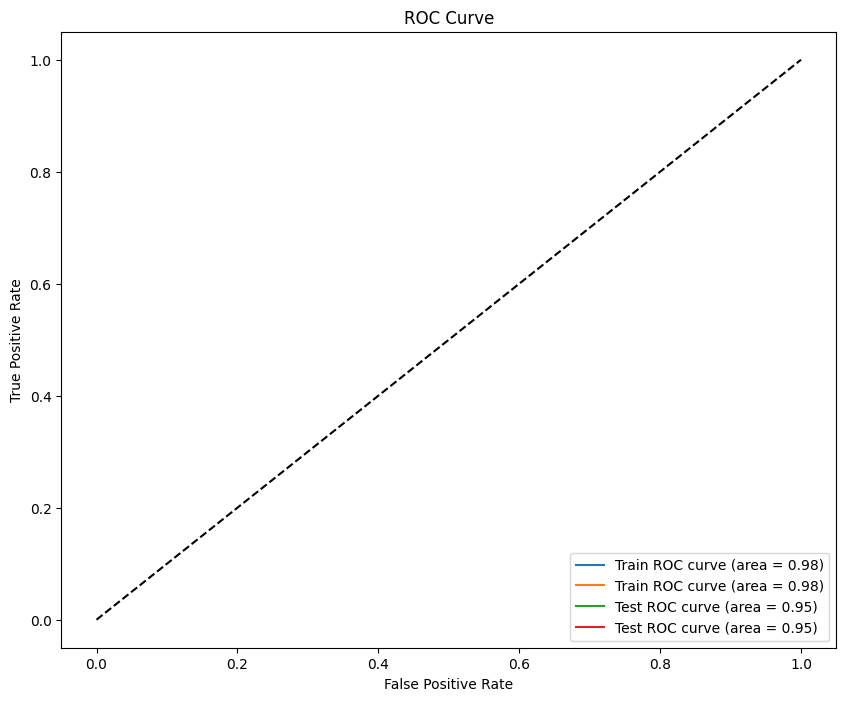

In [9]:
import matplotlib.pyplot as plt

# Assuming 'leader_model' is your trained H2O model
# And 'train_h2o' and 'test_h2o' are your H2OFrame training and test sets

# Calculate model performance on training and test sets
train_perf = leader_model.model_performance(train_h2o)
test_perf = leader_model.model_performance(test_h2o)

# Get ROC curve data
train_tpr = train_perf.tpr()  # True Positive Rate
train_fpr = train_perf.fpr()  # False Positive Rate
test_tpr = test_perf.tpr()
test_fpr = test_perf.fpr()

# AUC scores
train_auc = train_perf.auc()
test_auc = test_perf.auc()

# Plotting ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(train_fpr, train_tpr, label=f'Train ROC curve (area = {train_auc:.2f})')
plt.plot(test_fpr, test_tpr, label=f'Test ROC curve (area = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [12]:
# Assuming 'leader_model' is your trained H2O AutoML leader model
model_path = h2o.save_model(model=leader_model, path="/content/", force=True)

print(f"Model saved to: {model_path}")



Model saved to: /content/GBM_3_AutoML_1_20240211_175657


In [14]:
loaded_model = h2o.load_model("//content/GBM_3_AutoML_1_20240211_175657")  # Adjust the path and filename


In [15]:
train_perf = loaded_model.model_performance(train_h2o)
test_perf = loaded_model.model_performance(test_h2o)


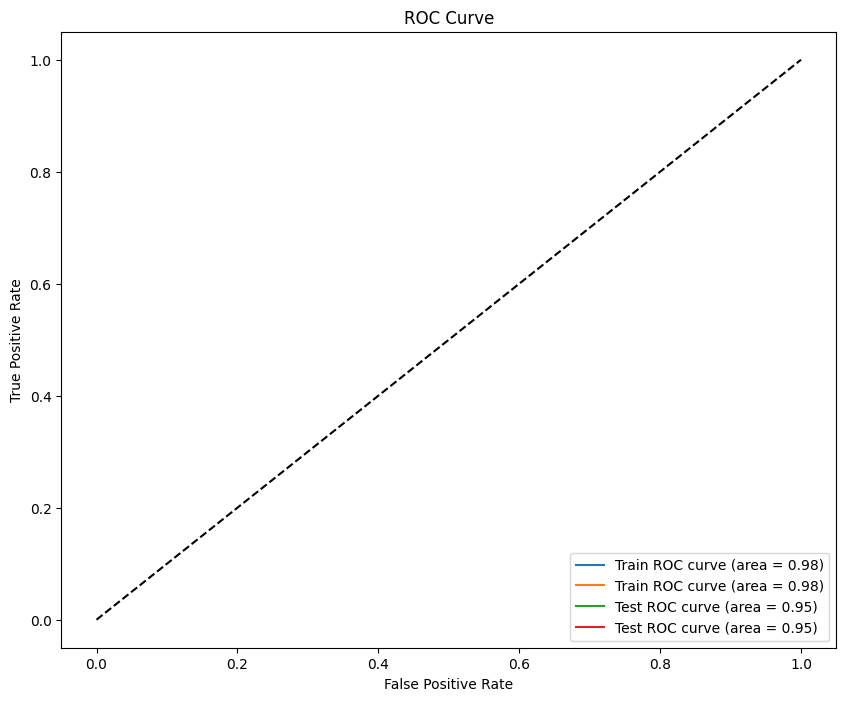

In [16]:
import matplotlib.pyplot as plt

# Get ROC curve data
train_tpr = train_perf.tpr()  # True Positive Rate
train_fpr = train_perf.fpr()  # False Positive Rate
test_tpr = test_perf.tpr()
test_fpr = test_perf.fpr()

# AUC scores
train_auc = train_perf.auc()
test_auc = test_perf.auc()

# Plotting ROC Curve
plt.figure(figsize=(10, 8))
plt.plot(train_fpr, train_tpr, label=f'Train ROC curve (area = {train_auc:.2f})')
plt.plot(test_fpr, test_tpr, label=f'Test ROC curve (area = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [17]:
# Check performance metrics and confusion matrix
train_cm = train_perf.confusion_matrix()
test_cm = test_perf.confusion_matrix()

print("Training Confusion Matrix:")
train_cm.show()

print("Test Confusion Matrix:")
test_cm.show()


Training Confusion Matrix:


,0,1,Error,Rate
0,1010.0,89.0,0.081,(89.0/1099.0)
1,59.0,1040.0,0.0537,(59.0/1099.0)
Total,1069.0,1129.0,0.0673,(148.0/2198.0)


Test Confusion Matrix:


,0,1,Error,Rate
0,348.0,18.0,0.0492,(18.0/366.0)
1,1.0,36.0,0.027,(1.0/37.0)
Total,349.0,54.0,0.0471,(19.0/403.0)


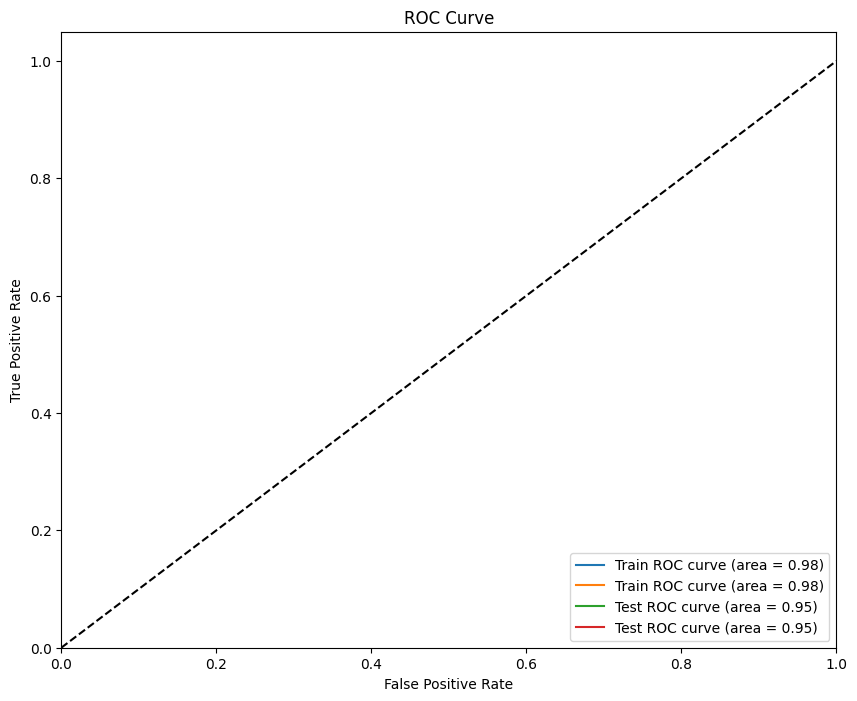

In [18]:
# Plot ROC Curve again with adjusted axis limits and ensure plot details are visible
plt.figure(figsize=(10, 8))
plt.plot(train_fpr, train_tpr, label=f'Train ROC curve (area = {train_auc:.2f})')
plt.plot(test_fpr, test_tpr, label=f'Test ROC curve (area = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [19]:
# Calculate performance on training data
train_perf = loaded_model.model_performance(train_h2o)

# Calculate performance on test data
test_perf = loaded_model.model_performance(test_h2o)


In [24]:
# Define a function to extract metrics
def print_metrics(perf, dataset_name):
    f1_score = perf.F1()[0][1]
    precision = perf.precision()[0][1]
    recall = perf.recall()[0][1]
    specificity = perf.specificity()[0][1]
    cm = perf.confusion_matrix().to_list()  # Convert to list
    sensitivity = cm[1][1] / (cm[1][1] + cm[1][0])  # True Positive Rate

    print(f"{dataset_name} Set Metrics:")
    print(f"F1 Score: {f1_score}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print("Confusion Matrix:")
    for line in cm:
        print("\t".join(map(str, line)))
    print("\n")

# Assuming you have train_perf and test_perf already calculated
print_metrics(train_perf, "Training")
print_metrics(test_perf, "Test")


Training Set Metrics:
F1 Score: 0.933572710951526
Precision: 1.0
Recall: 1.0
Sensitivity: 0.9463148316651502
Specificity: 1.0
Confusion Matrix:
1010	89
59	1040


Test Set Metrics:
F1 Score: 0.7912087912087912
Precision: 1.0
Recall: 1.0
Sensitivity: 0.972972972972973
Specificity: 1.0
Confusion Matrix:
348	18
1	36




In [25]:
# Assuming you have a trained model and a test set ready
test_predictions = loaded_model.predict(test_h2o)['p1']  # Get the probability of the positive class

# Define a function to apply a custom threshold and calculate new metrics
def apply_threshold_and_get_metrics(predictions, actuals, threshold):
    # Apply the threshold to the positive class probabilities to get new predictions
    new_predictions = predictions > threshold
    new_confusion_matrix = actuals.cbind(new_predictions).as_data_frame()
    new_confusion_matrix.columns = ['actual', 'predicted']

    # Calculate new metrics
    tp = sum((new_confusion_matrix['actual'] == 1) & (new_confusion_matrix['predicted'] == 1))
    fn = sum((new_confusion_matrix['actual'] == 1) & (new_confusion_matrix['predicted'] == 0))
    sensitivity = tp / (tp + fn)

    print(f"Sensitivity (Recall) at threshold {threshold}: {sensitivity}")
    print(f"New Confusion Matrix at threshold {threshold}:")
    print(pd.crosstab(new_confusion_matrix['actual'], new_confusion_matrix['predicted'], rownames=['Actual'], colnames=['Predicted']))

# Apply a lower threshold to prioritize reducing false negatives
apply_threshold_and_get_metrics(test_predictions, test_h2o[target], threshold=0.3)  # Adjust threshold as needed


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Sensitivity (Recall) at threshold 0.3: 0.972972972972973
New Confusion Matrix at threshold 0.3:
Predicted    0   1
Actual            
0          314  52
1            1  36


In [26]:
# Define a function to extract metrics
def print_metrics(perf, dataset_name):
    f1_score = perf.F1()[0][1]
    precision = perf.precision()[0][1]
    recall = perf.recall()[0][1]
    specificity = perf.specificity()[0][1]
    cm = perf.confusion_matrix().to_list()  # Convert to list
    sensitivity = cm[1][1] / (cm[1][1] + cm[1][0])  # True Positive Rate

    print(f"{dataset_name} Set Metrics:")
    print(f"F1 Score: {f1_score}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print("Confusion Matrix:")
    for line in cm:
        print("\t".join(map(str, line)))
    print("\n")

# Assuming you have train_perf and test_perf already calculated
print_metrics(train_perf, "Training")
print_metrics(test_perf, "Test")


Training Set Metrics:
F1 Score: 0.933572710951526
Precision: 1.0
Recall: 1.0
Sensitivity: 0.9463148316651502
Specificity: 1.0
Confusion Matrix:
1010	89
59	1040


Test Set Metrics:
F1 Score: 0.7912087912087912
Precision: 1.0
Recall: 1.0
Sensitivity: 0.972972972972973
Specificity: 1.0
Confusion Matrix:
348	18
1	36




In [28]:
def print_metrics_with_threshold(perf, threshold, dataset_name):
    # Apply the threshold to get the confusion matrix
    cm = perf.confusion_matrix(thresholds=[threshold]).table.as_data_frame()
    tp = int(cm.iloc[1,1])
    fn = int(cm.iloc[1,0])
    fp = int(cm.iloc[0,1])
    tn = int(cm.iloc[0,0])

    # Calculate the new sensitivity and specificity
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = sensitivity  # recall is the same as sensitivity

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"{dataset_name} Set Metrics at Threshold {threshold}:")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall (Sensitivity): {recall}")
    print(f"Specificity: {specificity}")
    print("Confusion Matrix:")
    print(cm)
    print("\n")

# Determine a new threshold that might reduce false negatives
new_threshold = 0.4  # This is an example value, adjust based on your model's ROC curve

# Print adjusted metrics for training set
print_metrics_with_threshold(train_perf, new_threshold, "Training")

# Print adjusted metrics for test set
print_metrics_with_threshold(test_perf, new_threshold, "Test")


Could not find exact threshold 0.4; using closest threshold found 0.379559252683754.
Training Set Metrics at Threshold 0.4:
F1 Score: 0.09927797833935019
Precision: 0.05228136882129278
Recall (Sensitivity): 0.9821428571428571
Specificity: 0.0
Confusion Matrix:
               0       1   Error             Rate
0      0   997.0   102.0  0.0928   (102.0/1099.0)
1      1    55.0  1044.0    0.05    (55.0/1099.0)
2  Total  1052.0  1146.0  0.0714   (157.0/2198.0)


Could not find exact threshold 0.4; using closest threshold found 0.379559252683754.
Test Set Metrics at Threshold 0.4:
F1 Score: 0.00617283950617284
Precision: 0.003105590062111801
Recall (Sensitivity): 0.5
Specificity: 0.0
Confusion Matrix:
              0     1   Error           Rate
0      0  321.0  45.0   0.123   (45.0/366.0)
1      1    1.0  36.0   0.027     (1.0/37.0)
2  Total  322.0  81.0  0.1141   (46.0/403.0)




In [29]:
# Define a function to extract metrics
def print_metrics(perf, dataset_name):
    f1_score = perf.F1()[0][1]
    precision = perf.precision()[0][1]
    recall = perf.recall()[0][1]
    specificity = perf.specificity()[0][1]
    cm = perf.confusion_matrix().to_list()  # Convert to list
    sensitivity = cm[1][1] / (cm[1][1] + cm[1][0])  # True Positive Rate

    print(f"{dataset_name} Set Metrics:")
    print(f"F1 Score: {f1_score}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    print("Confusion Matrix:")
    for line in cm:
        print("\t".join(map(str, line)))
    print("\n")

# Assuming you have train_perf and test_perf already calculated
print_metrics(train_perf, "Training")
print_metrics(test_perf, "Test")


Training Set Metrics:
F1 Score: 0.933572710951526
Precision: 1.0
Recall: 1.0
Sensitivity: 0.9463148316651502
Specificity: 1.0
Confusion Matrix:
1010	89
59	1040


Test Set Metrics:
F1 Score: 0.7912087912087912
Precision: 1.0
Recall: 1.0
Sensitivity: 0.972972972972973
Specificity: 1.0
Confusion Matrix:
348	18
1	36




In [30]:
# Assuming you have an H2OAutoML object named `automl`
leader_model = automl.leader

# Print the model details
print("Best Model Type: ", leader_model.algo)  # Type of the model
print("Best Model ID: ", leader_model.model_id)  # Identifier for the model
print("Best Model Performance: ")
print(leader_model.cross_validation_metrics_summary())  # Cross-validated performance metrics summary

# For more detailed model parameters and settings
print("Model Parameters: ")
print(leader_model.params)

# To get the full model details in JSON format, which includes everything about the model
print("Full Model Details: ")
model_details = leader_model.get_params()
print(model_details)


Best Model Type:  gbm
Best Model ID:  GBM_3_AutoML_1_20240211_175657
Best Model Performance: 
Cross-Validation Metrics Summary: 
                         mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.929487   0.0116702   0.927273      0.931818      0.915909      0.924829      0.947608
auc                      0.971287   0.00889954  0.965221      0.971618      0.973146      0.961628      0.98482
err                      0.0705125  0.0116702   0.0727273     0.0681818     0.0840909     0.0751708     0.0523918
err_count                31         5.14781     32            30            37            33            23
f0point5                 0.92633    0.0138682   0.940212      0.919283      0.907906      0.92437       0.939881
f1                       0.929699   0.0126828   0.924171      0.931818      0.91

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from xgboost import XGBClassifier

In [4]:
import pandas as pd
df = pd.read_excel('//content/balanced_all_data_TargetOnly_ADASYN.xlsx')
df.shape

(2941, 17)

In [5]:
df.STATUS_dead_alive.value_counts()

1    1476
0    1465
Name: STATUS_dead_alive, dtype: int64

In [6]:

# Assuming df is your DataFrame and it's ready for use
X = df.drop('STATUS_dead_alive', axis=1)  # Features
y = df['STATUS_dead_alive']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [7]:
import numpy as np
import pandas as pd

# Assuming you already have the test set and the label "STATUS_dead_alive" in y_test
# You can obtain the unique classes and their counts as follows:

# Find unique classes in the test set
unique_classes = np.unique(y_test)

# Count the number of samples for each unique class
class_counts = pd.Series(y_test).value_counts()

# Print the unique classes and their counts
print("Unique Classes in Test Set:", unique_classes)
print("Class Distribution in Test Set:")
print(class_counts)

Unique Classes in Test Set: [0 1]
Class Distribution in Test Set:
1    296
0    293
Name: STATUS_dead_alive, dtype: int64


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming you have loaded your DataFrame into df

# Separate features and target
X = df.drop(columns=['STATUS_dead_alive'])  # Features
y = df['STATUS_dead_alive']  # Target

# Convert the features to binary integers if they are not already
X = X.astype(int)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the desired class distribution for the test set
desired_class_distribution = {0: 0.7, 1: 0.3}

# Adjust the class distribution in the test set manually
class1_indices = y_test[y_test == 1].sample(frac=desired_class_distribution[1]).index
class0_indices = y_test[y_test == 0].sample(frac=desired_class_distribution[0]).index

# Combine the selected samples into the final test set
balanced_df_test = pd.concat([X_test.loc[class1_indices], X_test.loc[class0_indices]])
y_test_balanced = pd.concat([y_test.loc[class1_indices], y_test.loc[class0_indices]])

# Combine the features and target into a DataFrame for testing
balanced_df_test = pd.concat([balanced_df_test, y_test_balanced], axis=1)

# Save the balanced test set to an Excel file
balanced_df_test.to_excel('balanced_test_data.xlsx', index=False)

In [9]:
X_test = balanced_df_test.drop(columns=['STATUS_dead_alive'])
y_test = balanced_df_test['STATUS_dead_alive']

In [10]:
import numpy as np
import pandas as pd

# Assuming you already have the test set and the label "STATUS_dead_alive" in y_test
# You can obtain the unique classes and their counts as follows:

# Find unique classes in the test set
unique_classes = np.unique(y_test)

# Count the number of samples for each unique class
class_counts = pd.Series(y_test).value_counts()

# Print the unique classes and their counts
print("Unique Classes in Test Set:", unique_classes)
print("Class Distribution in Test Set:")
print(class_counts)

Unique Classes in Test Set: [0 1]
Class Distribution in Test Set:
0    204
1     89
Name: STATUS_dead_alive, dtype: int64


In [36]:
from tpot import TPOTClassifier
from sklearn.metrics import f1_score
import joblib

# Instantiate TPOTClassifier
tpot = TPOTClassifier(generations=50, population_size=20, verbosity=2, random_state=42,
                      early_stop=8, scoring='f1', config_dict="TPOT sparse")

# Fit TPOT on the training data
tpot.fit(X_train, y_train)

# Score the optimized pipeline on the test set
test_score = tpot.score(X_test, y_test)
print(f"F1 Score on Test Set: {test_score}")

# Score the optimized pipeline on the train set
train_score = tpot.score(X_train, y_train)
print(f"F1 Score on Train Set: {train_score}")

# Print the best pipeline
print("Best pipeline steps:", end="\n")
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    print(f"{idx}. {name}")

# Save the best pipeline to a Python file
tpot.export('tpot_best_pipeline.py')

# Save the trained model
joblib.dump(tpot.fitted_pipeline_, 'tpot_trained_model.pkl')


Optimization Progress:   0%|          | 0/1020 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9379270886717039

Generation 2 - Current best internal CV score: 0.9400495036406724

Generation 3 - Current best internal CV score: 0.9400495036406724

Generation 4 - Current best internal CV score: 0.9415707773322103

Generation 5 - Current best internal CV score: 0.9440140283149739

Generation 6 - Current best internal CV score: 0.9444234070986932

Generation 7 - Current best internal CV score: 0.9464468741865971

Generation 8 - Current best internal CV score: 0.9464468741865971

Generation 9 - Current best internal CV score: 0.9464468741865971

Generation 10 - Current best internal CV score: 0.9464468741865971

Generation 11 - Current best internal CV score: 0.9464468741865971

Generation 12 - Current best internal CV score: 0.9464468741865971

Generation 13 - Current best internal CV score: 0.9468568068930864

Generation 14 - Current best internal CV score: 0.9468568068930864

Generation 15 - Current best internal CV score: 0.946856

['tpot_trained_model.pkl']

In [37]:
tpot.export('optimized_pipeline.py')
from joblib import dump


In [38]:
from joblib import dump

# Save the trained TPOT model
dump(tpot.fitted_pipeline_, 'tpot_trained_model.joblib')


['tpot_trained_model.joblib']

In [39]:
from joblib import load
# Load the saved TPOT model
tpot_model = load('tpot_trained_model.joblib')


tpot.fitted_pipeline_


Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_features=0.55, min_samples_split=15,
                                        random_state=42))])

In [40]:

tpot.score(X_test, y_test)



0.9032258064516129

In [41]:
tpot.score(X_train, y_train)

0.9558638083228246

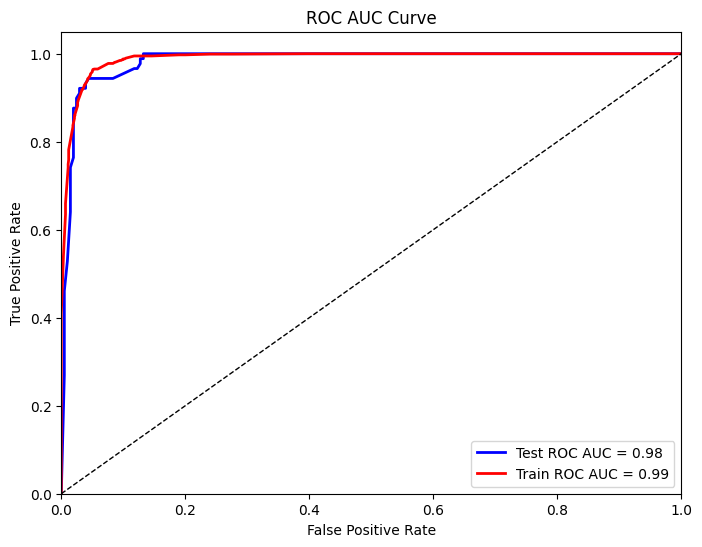

In [42]:
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Load the trained model
tpot_trained_model = joblib.load('tpot_trained_model.pkl')

# Predict probabilities on the test and train sets
y_test_probs = tpot_trained_model.predict_proba(X_test)[:, 1]
y_train_probs = tpot_trained_model.predict_proba(X_train)[:, 1]

# Calculate ROC AUC score for test set
test_roc_auc = roc_auc_score(y_test, y_test_probs)

# Calculate ROC AUC score for train set
train_roc_auc = roc_auc_score(y_train, y_train_probs)

# Compute ROC curve for test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)

# Compute ROC curve for train set
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)

# Plot ROC AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'Test ROC AUC = {test_roc_auc:.2f}')
plt.plot(fpr_train, tpr_train, color='red', lw=2, label=f'Train ROC AUC = {train_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()

In [43]:
import joblib
from sklearn.metrics import confusion_matrix

# Load the trained model
tpot_trained_model = joblib.load('tpot_trained_model.pkl')

# Predict labels on the test and train sets
y_test_pred = tpot_trained_model.predict(X_test)
y_train_pred = tpot_trained_model.predict(X_train)

# Compute confusion matrix for test set
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred).ravel()

# Compute confusion matrix for train set
tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_train_pred).ravel()

# Print the results
print("Test Set:")
print(f"True Positives: {tp_test}")
print(f"True Negatives: {tn_test}")
print(f"False Positives: {fp_test}")
print(f"False Negatives: {fn_test}")
print()
print("Train Set:")
print(f"True Positives: {tp_train}")
print(f"True Negatives: {tn_train}")
print(f"False Positives: {fp_train}")
print(f"False Negatives: {fn_train}")


Test Set:
True Positives: 84
True Negatives: 191
False Positives: 13
False Negatives: 5

Train Set:
True Positives: 1137
True Negatives: 1110
False Positives: 64
False Negatives: 41


In [44]:
import joblib
import numpy as np
from sklearn.metrics import confusion_matrix

# Load the trained model
tpot_trained_model = joblib.load('tpot_trained_model.pkl')

# Predict probabilities on the test set
y_test_probs = tpot_trained_model.predict_proba(X_test)[:, 1]

# Adjust the threshold to reduce false negatives
threshold = 0.5  # Example threshold, you can adjust it as needed
y_test_pred = np.where(y_test_probs > threshold, 1, 0)

# Compute confusion matrix for test set
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred).ravel()

# Print the results
print("Test Set:")
print(f"True Positives: {tp_test}")
print(f"True Negatives: {tn_test}")
print(f"False Positives: {fp_test}")
print(f"False Negatives: {fn_test}")


Test Set:
True Positives: 84
True Negatives: 191
False Positives: 13
False Negatives: 5


In [45]:
# Load the trained model
tpot_trained_model = joblib.load('tpot_trained_model.pkl')

# Predict probabilities on the test and train sets
y_test_probs = tpot_trained_model.predict_proba(X_test)[:, 1]
y_train_probs = tpot_trained_model.predict_proba(X_train)[:, 1]

# Adjust the prediction threshold
threshold = 0.2  # Example threshold, adjust as needed
y_test_pred_adjusted = (y_test_probs > threshold).astype(int)
y_train_pred_adjusted = (y_train_probs > threshold).astype(int)

# Compute confusion matrix for test set
tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_test_pred_adjusted).ravel()

# Compute confusion matrix for train set
tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_train_pred_adjusted).ravel()

# Print the results
print("Adjusted Test Set:")
print(f"True Positives: {tp_test}")
print(f"True Negatives: {tn_test}")
print(f"False Positives: {fp_test}")
print(f"False Negatives: {fn_test}")
print()
print("Adjusted Train Set:")
print(f"True Positives: {tp_train}")
print(f"True Negatives: {tn_train}")
print(f"False Positives: {fp_train}")
print(f"False Negatives: {fn_train}")


Adjusted Test Set:
True Positives: 89
True Negatives: 174
False Positives: 30
False Negatives: 0

Adjusted Train Set:
True Positives: 1172
True Negatives: 1026
False Positives: 148
False Negatives: 6


In [46]:
# Calculate Sensitivity (True Positive Rate or Recall)
sensitivity_test = tp_test / (tp_test + fn_test)
sensitivity_train = tp_train / (tp_train + fn_train)

# Calculate Specificity (True Negative Rate)
specificity_test = tn_test / (tn_test + fp_test)
specificity_train = tn_train / (tn_train + fp_train)

# Calculate Accuracy
accuracy_test = (tp_test + tn_test) / (tp_test + tn_test + fp_test + fn_test)
accuracy_train = (tp_train + tn_train) / (tp_train + tn_train + fp_train + fn_train)

# Calculate Precision (Positive Predictive Value)
precision_test = tp_test / (tp_test + fp_test)
precision_train = tp_train / (tp_train + fp_train)

# Calculate F1 Score
f1_score_test = 2 * (precision_test * sensitivity_test) / (precision_test + sensitivity_test)
f1_score_train = 2 * (precision_train * sensitivity_train) / (precision_train + sensitivity_train)

# Calculate Positive Predictive Value (Precision) and Negative Predictive Value
ppv_test = precision_test
ppv_train = precision_train
npv_test = tn_test / (tn_test + fn_test)
npv_train = tn_train / (tn_train + fn_train)

# Calculate Positive Likelihood Ratio and Negative Likelihood Ratio
lr_pos_test = sensitivity_test / (1 - specificity_test)
lr_pos_train = sensitivity_train / (1 - specificity_train)
lr_neg_test = (1 - sensitivity_test) / specificity_test
lr_neg_train = (1 - sensitivity_train) / specificity_train

# Print the results
print("Test Set:")
print(f"Sensitivity: {sensitivity_test:.2f}")
print(f"Specificity: {specificity_test:.2f}")
print(f"Accuracy: {accuracy_test:.2f}")
print(f"Precision: {precision_test:.2f}")
print(f"F1 Score: {f1_score_test:.2f}")
print(f"Positive Predictive Value: {ppv_test:.2f}")
print(f"Negative Predictive Value: {npv_test:.2f}")
print(f"Positive Likelihood Ratio: {lr_pos_test:.2f}")
print(f"Negative Likelihood Ratio: {lr_neg_test:.2f}")
print()

print("Train Set:")
print(f"Sensitivity: {sensitivity_train:.2f}")
print(f"Specificity: {specificity_train:.2f}")
print(f"Accuracy: {accuracy_train:.2f}")
print(f"Precision: {precision_train:.2f}")
print(f"F1 Score: {f1_score_train:.2f}")
print(f"Positive Predictive Value: {ppv_train:.2f}")
print(f"Negative Predictive Value: {npv_train:.2f}")
print(f"Positive Likelihood Ratio: {lr_pos_train:.2f}")
print(f"Negative Likelihood Ratio: {lr_neg_train:.2f}")


Test Set:
Sensitivity: 1.00
Specificity: 0.85
Accuracy: 0.90
Precision: 0.75
F1 Score: 0.86
Positive Predictive Value: 0.75
Negative Predictive Value: 1.00
Positive Likelihood Ratio: 6.80
Negative Likelihood Ratio: 0.00

Train Set:
Sensitivity: 0.99
Specificity: 0.87
Accuracy: 0.93
Precision: 0.89
F1 Score: 0.94
Positive Predictive Value: 0.89
Negative Predictive Value: 0.99
Positive Likelihood Ratio: 7.89
Negative Likelihood Ratio: 0.01


In [34]:
!pip install tpot